# <img style="float: left; padding-right: 10px; width: 45px" src="iacs.png"> S-109A Introduction to Data Science: 

## Homework 5: Ensemble Methods, and Neural Networks


**Harvard University**<br/>
**Summer 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



In [14]:
from IPython.core.display import HTML
def css_styling(): styles = open("cs109.css", "r").read(); return HTML(styles)
css_styling()

## Assumed Skills:
This assignment presumes knowledge of the following skills:
- Familiarity with sklearn's model objects
- Cross validation to estimate models' future performance
- Booststrapping to build alternative datasets
- Some instruction on Keras' interface for building and training neural networks

Import libraries:

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV

from keras.models import Sequential
from keras.layers import Dense

%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)
sns.set()


# Higgs Boson Discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. We shall explore the use of ensemble methods for this classification task.

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background). 

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: <a href = "https://www.nature.com/articles/ncomms5308">Baldi et al., Nature Communications 5, 2014</a>.

In [16]:
data_train = pd.read_csv('data/Higgs_train.csv')
data_test = pd.read_csv('data/Higgs_test.csv')

In [17]:
data_train.head()

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0


In [18]:
X_train = data_train.iloc[:, data_train.columns != 'class']
y_train = data_train['class'].values
X_test = data_test.iloc[:, data_test.columns != 'class']
y_test = data_test['class'].values

## Question 1 (12pts): A Single Model
We start by fitting a basic model we can compare the other models to. We'll pick an optimally-tuned decision tree as the base model, because we'll later include random forests and want a fair comparison.

<div class='exercise'> Question 1</div>
** 1.1**  Fit a decision tree model to the training set. Determine the depth-of-tree parameter via 5-fold cross-validation and plot the estimated performance +/- 2 standard deviations for the various depths.

** 1.2** Select an appropriate maximum depth-of-tree, and justify your choice.

**1.3** Report the model's classification accuracy on the test set.

**Answers**:  
**1.1:** Fit a decision tree model to the training set. Determine the depth-of-tree parameter via 5-fold cross-validation and plot the estimated performance +/- 2 standard deviations for the various depths.

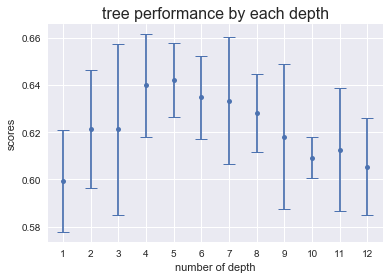

In [19]:
#define list, and depth
mean = []
std = []
depth = np.arange(1,13) #check depth 1 to 12

for i in depth: #make mean,std list
    model = DecisionTreeClassifier(max_depth=i)
    scores = cross_val_score(model, X_train,y_train, cv=5)
    mean.append(scores.mean())
    std.append(scores.std()*2)
    
#plot each one with +- 2std
plt.errorbar(depth,mean,yerr=std,fmt='o',markersize=5, capsize=6,capthick=1)
plt.title("tree performance by each depth",fontsize=16)
plt.xticks(depth)
plt.xlabel("number of depth")
plt.ylabel("scores");

** 1.2** Select an apropriate maximum depth-of-tree, and justify your choice.

----
Your answer here

----

I would choose maximum 5 depth of tree.

Because as you can see above, 5 has the highest mean CV score, 

and relatively small +-2 standard deviation range.

**1.3** Report the model's classification accuracy on the test set.

In [20]:
# your code here
from sklearn.metrics import accuracy_score
#use accuracy_score
decisiontree_model = DecisionTreeClassifier(max_depth=5).fit(X_train,y_train)
print("the model's classification accuracy score : {0}"
      .format(accuracy_score(y_test,decisiontree_model.predict(X_test))))

the model's classification accuracy score : 0.648


## Question 2 (14 pts): Bagging
Bagging is the technique of building the same model on multiple bootstraps from the data and combining each model's prediction to get an overall classification. In this question we build an example by hand and study how the number of bootstrapped datasets impacts the combined accuracy.

<div class='exercise'> Question 2</div>
**2.1** Create 25 bootstrapped replications of the original training data, and fit a decision tree of depth 5 to each. Record each tree's prediction. In particular, produce a dataset like those below, where each row is a training example, each column is a tree from the forest, and each entry is that tree's prediction for that training example.

`bagging_train`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 25's prediction|
| --- | --- | --- | --- |
|training row 1| binary value | binary value|... |binary value|
|training row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |

`bagging_test`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 25's prediction|
| --- | --- | --- | --- |
|test row 1| binary value | binary value|... |binary value|
|test row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |

Store these results as `bagging_train` and `bagging_test`.

**2.2** _Aggregate_ all 25 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the 25 models predict that example to be from class 1. Verify that this bagging model scores either 67% or 68% accuracy on the test set.

**2.3** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `sequential_prediction` function to get the model's accuracy score when using only 1,2,3,4,... of the bootstrapped models. Make a plot of training and test set accuracy as a function of number of bootstraps.

**2.4** Analyze the graph from 2.3 and discuss the effect of adding more bootstrapped models to the ensemble. What number of trees would you use in a production model to be cost-effective?

**Hints**
- Use `resample` from sklearn to easily bootstrap the x and y data.
- use `np.mean` to easily test for majority. If a majority of models vote 1, what does that imply about the mean?

In [21]:
def running_predictions(prediction_dataset, targets):
    """A function to predict examples' class via the majority among trees (ties are predicted as 0)
    
    Inputs:
      prediction_dataset - a (n_examples by n_sub_models) dataset, where each entry [i,j] is sub-model j's prediction
          for example i
      targets - the true class labels
    
    Returns:
      a vector where vec[i] is the model's accuracy when using just the first i+1 sub-models
    """
    
    n_trees = prediction_dataset.shape[1]
    
    # find the running percentage of models voting 1 as more models are considered
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    
    
    
    return np.mean(running_correctnesss,axis=0)
    # returns a 1-d series of the accuracy of using the first n trees to predict the targets

**Answers**:  
**2.1** Create 25 bootstrapped replications of the original training data, and fit a decision tree of depth 5 to each. In particular, produce a dataset similar to 2.1, where each row is a training example, each column is a tree from the forest, but each entry is that tree's prediction of the _probability_ that training example comes from class 1.

In [22]:
# your code here
#make index name
train_index_name =['training row {0}'.format(i+1) for i in range(len(X_train))]
test_index_name =['test row {0}'.format(i+1) for i in range(len(X_test))]
#make empty dataframe with index i made
bagging_train = pd.DataFrame(index=train_index_name)
bagging_test = pd.DataFrame(index=test_index_name)

for i in np.arange(1,26): #make dataframe with bootstrap data.
    bootstrap_X_train,bootstrap_y_train = resample(X_train,y_train, replace=True,n_samples=len(X_train))
    #bootstrap from X_train, y_train
    boot_model = DecisionTreeClassifier(max_depth=5).fit(bootstrap_X_train,bootstrap_y_train)
    #fit in decisiontree
    bagging_train["bootstrap model {0}'s prediction".format(i)] = [i[1] for i in boot_model.predict_proba(X_train)]
    bagging_test["bootstrap model {0}'s prediction".format(i)] = [i[1] for i in boot_model.predict_proba(X_test)]
    #store it in dataframe
    
bagging_train.head()

,bootstrap model 1's prediction,bootstrap model 2's prediction,bootstrap model 3's prediction,bootstrap model 4's prediction,bootstrap model 5's prediction,bootstrap model 6's prediction,bootstrap model 7's prediction,bootstrap model 8's prediction,bootstrap model 9's prediction,bootstrap model 10's prediction,bootstrap model 11's prediction,bootstrap model 12's prediction,bootstrap model 13's prediction,bootstrap model 14's prediction,bootstrap model 15's prediction,bootstrap model 16's prediction,bootstrap model 17's prediction,bootstrap model 18's prediction,bootstrap model 19's prediction,bootstrap model 20's prediction,bootstrap model 21's prediction,bootstrap model 22's prediction,bootstrap model 23's prediction,bootstrap model 24's prediction,bootstrap model 25's prediction
training row 1,0.625917,0.627692,0.421053,0.604990,0.661871,0.738889,0.653846,0.704289,0.711896,0.460630,0.668531,0.551817,0.646465,0.776669,0.710145,0.680982,0.715686,0.665421,0.620309,0.682971,0.654962,0.525368,0.742769,0.830813,0.645210
training row 2,0.130631,0.769231,0.288265,0.284091,0.290000,0.782609,0.298701,0.576720,0.251534,0.297593,0.272727,0.082645,0.678832,0.276224,0.068493,0.325112,0.682353,0.227586,0.237903,0.434783,0.171717,0.312169,0.263291,0.206186,0.423295
training row 3,0.358871,0.468635,0.530000,0.521595,0.888889,0.825000,0.276382,0.576720,0.251534,0.297593,0.302817,0.684932,0.794118,0.712500,0.177966,0.325112,0.361991,0.619266,0.581081,0.423077,0.260870,0.380165,0.530726,0.208333,0.423295
training row 4,0.438819,0.255474,0.672515,0.521595,0.290000,0.400000,0.333333,0.619048,0.776471,0.888889,0.865854,0.684932,0.135314,0.923077,0.656766,0.727273,0.264516,0.619266,0.581081,0.676471,0.524324,0.127517,0.257895,0.208333,0.442136
training row 5,0.321678,0.372973,0.332298,0.355049,0.514523,0.304348,0.238636,0.525000,0.667732,0.462168,0.321280,0.372917,0.469734,0.286792,0.286344,0.234375,0.544248,0.334416,0.299694,0.231405,0.678801,0.208333,0.742769,0.830813,0.381818


**2.2** _Aggregate_ all 25 _bootstrapped_ models to get a single meta-prediction for each training and test point: predict a 1 if and only if the average of the 25 models' probability estimates for that point is above .5. Verify that this bagging model scores around 68% classification accuracy on the test set.

In [23]:
# your code here


meta_train_prediction = bagging_train.mean(axis=1).copy() #mean by column
meta_train_prediction = np.where(meta_train_prediction >= 0.5, 1,0) # predict if mean is above 0.5.

meta_test_prediction = bagging_test.mean(axis=1).copy()
meta_test_prediction = np.where(meta_test_prediction >= 0.5, 1,0)

#accuracy score
print('Meta-prediction classification accuracy on the test set: {0}'
      .format(np.sum(meta_test_prediction==y_test) / len(y_test)))


Meta-prediction classification accuracy on the test set: 0.6864


**2.3** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `sequential_prediction` function to get the model's accuracy score when using only 1,2,3,4,... of the bootstrapped models. Make a plot of training and test set accuracy as a function of number of bootstraps.

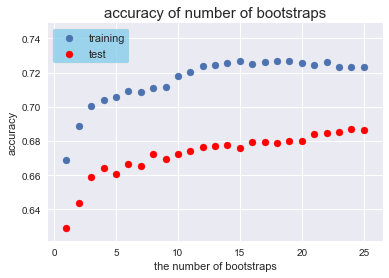

In [24]:
# your code here
#run the function
training_accuracy = running_predictions(bagging_train.values,y_train)
test_accuracy = running_predictions(bagging_test.values,y_test)

#plot
plt.scatter(np.arange(1,26),training_accuracy, label='training')
plt.scatter(np.arange(1,26),test_accuracy,color='r', label='test')
plt.xlabel("the number of bootstraps")
plt.ylabel("accuracy")
plt.title("accuracy of number of bootstraps", fontsize=15) 
plt.legend(fontsize=11,loc="upper left",frameon=True, facecolor='skyblue');


**2.4** Analyze the graph from 2.3 and discuss the effect of adding more bootstrapped models to the ensemble. What number of trees would you use in a production model to be cost-effective?

----
Your answer here

----


Small number of bootstraps in ensemble do not perform well. 

But the ensemble model is getting better and stable as the numbers increase.

The performance is peak around 16. 

But i would use around 6 number of bootstrap to be cost-effective.

Because at 5~10 numbers, the accuracy on test set is already quiet good and starts to be stable.
(only 1% increase until 16 bootstrap models.)


## Question 3 (6 pts): Random Forests
Random Forests are closely related to the bagging model we built by hand in question 2. In this question we compare our by-hand results with the results of using `RandomForestClassifier` directly.

<div class='exercise'> Question 3</div>
**3.1** Fit a `RandomForestClassifier` to the original `X_train` data using 25 trees and a depth of 5. Comment on the model's test performance compared to the bagging model from Question 2.

**3.2** There are two improvements Random Forests make to the pure boosting approach in Question 2. What are they, and how do they help the random forest model do better than the pure bagging model?

**Hints**:
 - Random forests do not combine each tree's prediction via a majority vote. What do they use instead?

## **Answers**:  
**3.1** Fit a `RandomForestClassifier` to the original `X_train` data using 25 trees and a depth of 5. Comment on the model's test performance compared to the model from Question 2.

In [26]:
# your code here
randomforestmodel = RandomForestClassifier(n_estimators=25 , max_depth=5).fit(X_train,y_train)
print('Randomforest accuracy : {0}'.format(accuracy_score(y_test,randomforestmodel.predict(X_test))))


Randomforest accuracy : 0.6744


----
Your answer here

----

Test performance is quite similiar to Question 2's model in this case. 

In this case RandomForest is slightly better on test set. (but sometimes worse)

One of the reason why is a risk of overfitting is lower.

Because the ensemble of trees in Bagging tends to be highly correlated when it has some strong predictor.


**3.2** There are two improvements Random Forests make to the pure bagging approach in Question 2. What are they, and how do they help the random forest model do better than the pure bagging model?

----
Your answer here

----

Random Forest is a modified form of bagging that creates ensembles of independent decision trees.

In this method, each tree, at each spilt it randomly selects a subset of predictors. And find the optimal predictor and the optimal corresponding threshold for the split.

And generally adding more trees will makes better accuracy in Random Forests.

and it produces model that is at least as robust as a single tree.

Comparing to bagging model, many trees does not affect to the risk of overfitting, because it selects predictors(feature)

randomly.


## Question 4 (12 pts): Boosting
In this question we explore a counterpart to bagging, where each new model is trained on a dataset weighted towards observations that the current set of models predicts incorrectly. 

We'll focus on the AdaBoost flavor of boosting and examine what happens to the ensemble model's accuracy over the algorithm's run.

<div class='exercise'> Question 4</div>
**4.1** Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 400 iterations. Use the `staged_score` method to help make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.  

**4.2** Repeat the plot above for a base learner with depth in (1,2,3,4). What trends do you see in the training and test accuracy?

**4.3** Based on the plot from 4.2, what combination of base learner depth and number of iterations seems optimal? Why?

**4.4** AdaBoost doesn't combine its sub-models via simple majority vote, or by averaging probabilities. What does it use instead, and why do you think that combination rule was chosen?

**Answers**:  
**4.1** Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 400 iterations. Use the `staged_score` method to help make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

In [27]:
# your code here
adaboostmodel = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3)
                                   ,n_estimators=400,learning_rate=0.05).fit(X_train,y_train)


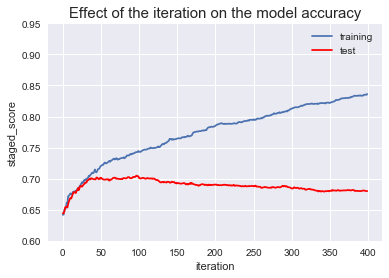

In [28]:
#store staged_score
stagescore_train = [i for i in adaboostmodel.staged_score(X_train,y_train)]
stagescore_test = [i for i in adaboostmodel.staged_score(X_test,y_test)]
#plot
plt.plot(stagescore_train, label="training")
plt.plot(stagescore_test, color='r', label="test")
plt.xlabel("iteration")
plt.ylabel("staged_score")
plt.title("Effect of the iteration on the model accuracy",fontsize=15)
plt.yticks(np.arange(0.60,1,0.05))
plt.legend();


**4.2** Repeat the plot above for a base learner with depth in (1,2,3,4). What trends do you see in the training and test accuracy?

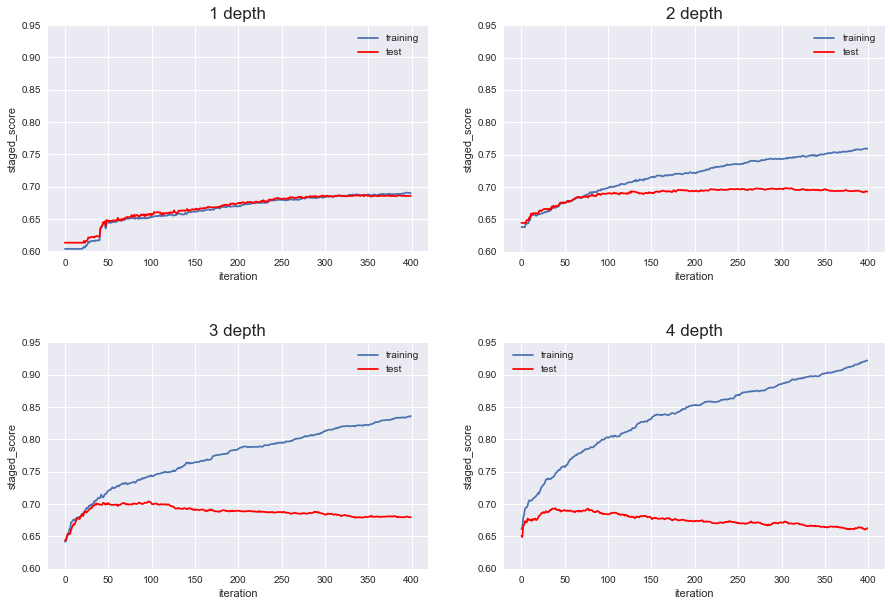

In [29]:
# your code here
#define depth and order
depth = [1,2,3,4]
order = [0,0,1,1]

fig,ax = plt.subplots(2,2,figsize=(15,10))
fig.subplots_adjust(hspace = 0.4)

for n,i in enumerate(depth): #use for loop to plot each.
    model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i),n_estimators=400
                       ,learning_rate=0.05).fit(X_train,y_train)
    stagescore_train = [i for i in model.staged_score(X_train,y_train)]
    stagescore_test = [i for i in model.staged_score(X_test,y_test)]
    
    ax[order[n],(i+1)%2].plot(stagescore_train, label="training")
    ax[order[n],(i+1)%2].plot(stagescore_test, color='r', label='test')
    ax[order[n],(i+1)%2].set_title("{0} depth".format(i), fontsize=17)
    ax[order[n],(i+1)%2].set_xlabel("iteration")
    ax[order[n],(i+1)%2].set_yticks(np.arange(0.60,1,0.05))
    ax[order[n],(i+1)%2].set_ylabel("staged_score")
    ax[order[n],(i+1)%2].legend()



----
Your answer here

----

As the iteration increases, score on training set increases and be overfitted.
But in the test set, the increment stops some point and be stable or getting worse becasue of overfiiting.

**4.3** Based on the plot from 4.2, what combination of base learner depth and number of iterations seems optimal? Why?


----
Your answer here

----
Performance on test set, the combination of 3 depth and 50~100 iteration is apparently the best choice.

Because around 0.7 is the best score in 1~4 depths. 

Reaching that point with adequate number of iteration is about 45~55 in 3 depth.

In 2 depth, it takes too many iteration to reach comparing to 3 depth.

**4.4** AdaBoost doesn't combine its sub-models via simple majority vote, or by averaging probabilities. What does it use instead, and why do you think that combination rule was chosen?

----
Your answer here

----

Boosting is the method which adds a new model in the previous model to decrease residuals.

So first, choose one model, and check the residuals, add a new model to reduce the residuals in the previous model, repeat this process.

Therefore, that is a reason when the iteration increases, the boosting model is more overfitting on training set.

When the model is overfitting on training set, of course the scores go down on the test set.

Depth is also similar to the iteration in terms of overfitting. Higher depth makes it more accuracy on the training set;overfitting.

Because a lot of condition(depth of tree) will overfit on the data. In other words, it will be worse on the test set.

That is one of the reason why the combination seems optimal.



## Question 5 (18 pts): Ensembling
In this question we take the running theme of combining model to its extreme. So far, we have been combining the predictions of relatively bad models; in this section we'll combine several strong models and achieve our best accuracy yet.

We provide well-tuned models in the file `models.pkl`. The code below will read in this data for you. The model_dict object contains 5 tuned models, under the names "Ada", "KNN", "Logit", "QDA", and "RF".

**5.1**: Report each of the 5 tuned models' score on the test set, so that you can compare to these scores later.

**5.2**: Read in the fresh dataset `data/Higgs_tune.csv` Similar to 2.1, build `ensemble_tune` and `ensemble_test`, datasets containing each tuned model's prediction of P(this point belongs to class 1) for each of the tuning and test points.

**5.3**: Build a meta-model trained on `ensemble_tune` and predicting the tuning set labels (e.g., a LogisticRegression or RandomForest). Which model does your meta-model consider most important, and how well does your meta-model perform on the test set?

**5.4**: Augment the `ensemble_tune` and `ensemble_test` datasets with the columns from the original tuning and test data to form `augmented_tune` and `augmented_test`. Fit a decision tree model to this new tuning data (max depth 5, no mximum number of features).

**5.5**: How well does the meta-tree do on the test set? Why does training a decision tree on the combination of original data and model predictions perform so well?

**5.6**: Suggest one way to improve on the model above

In [30]:
# will produce a warning under most versions of SKlearn, but it should be OK to ignore
# if you get weird errors or the models all stink, let us know

import pickle
with open("data/models.pkl", 'rb') as infile:
    model_dict = pickle.load(infile)

**Answers**:

**5.1**: Report each model's score on the test set, so that you can compare to these scores later.

In [31]:
# your code here

#sotre the scores
modelscore = [i.score(X_test,y_test) for i in model_dict.values()]

for i,n in zip(model_dict.keys(),modelscore):#print score with keys
    print("{0}'s score : {1}".format(i,n))  

Ada's score : 0.6756
RF's score : 0.6748
Logit's score : 0.6384
QDA's score : 0.633
KNN's score : 0.5774


**5.2**: Read in the fresh dataset `data/Higgs_tune.csv`.  Similar to 2.1, build `ensemble_tune` and `ensemble_test`, datasets containing each tuned model's prediction of P(this point belongs to class 1) for each of the tuning and test points.

In [32]:
# your code here
#read data
higges_data_set = pd.read_csv('data/Higgs_tune.csv')
#make X_tune and y_tune
X_tune = higges_data_set.iloc[:, higges_data_set.columns != 'class']
y_tune = higges_data_set['class'].values

In [33]:
# your code here
#make index name(same order of model_dict.keys)
tuned_model = ['Ada', 'RF', 'Logit', 'QDA', 'KNN']

tune_index_name =['ensemble_tune row {0}'.format(i+1) for i in range(len(X_tune))]
ensemble_test_index_name =['test row {0}'.format(i+1) for i in range(len(X_test))]                
                                                                                                                                    
#make empty dataframe with index i made
ensemble_tune = pd.DataFrame(index=tune_index_name)
ensemble_test = pd.DataFrame(index=ensemble_test_index_name)

#make dataset with prediction.
for n,i in zip(tuned_model,model_dict.values()):
    model = i.fit(X_train,y_train)
    ensemble_tune["{0}'s model prediction".format(n)] = [i[1] for i in i.predict_proba(X_tune)]
    ensemble_test["{0}'s model prediction".format(n)] = [i[1] for i in i.predict_proba(X_test)]
ensemble_tune.head()

,Ada's model prediction,RF's model prediction,Logit's model prediction,QDA's model prediction,KNN's model prediction
ensemble_tune row 1,0.476499,0.542357,0.712327,0.867147,0.60
ensemble_tune row 2,0.548898,0.613914,0.640878,0.766266,0.50
ensemble_tune row 3,0.455639,0.503966,0.439794,0.174581,0.70
ensemble_tune row 4,0.489579,0.428651,0.767450,0.759620,0.64
ensemble_tune row 5,0.465777,0.332388,0.208962,0.005958,0.50


**5.3**: Build a meta-model trained on `ensemble_tune` and predicting the tuning set labels (e.g., a LogisticRegression or RandomForest). Which model does your meta-model consider most important, and how well does your meta-model perform on the test set?

In [34]:
# your code here

meta_model = LogisticRegressionCV().fit(ensemble_tune,y_tune)
print("Weight of each model : {0}".format(meta_model.coef_))
print('most important model : {0}'.format(tuned_model[np.argmax(meta_model.coef_)]))
print('meta-model score : {0}'.format(accuracy_score(y_test,meta_model.predict(ensemble_test))))





Weight of each model : [[ 9.46577153  2.01217543  1.28768217  0.51609758 -0.27118766]]
most important model : Ada
meta-model score : 0.6928


----
Your answer here

----
The most important model in our meta-model is AdaBoost model. Highest coef level.(weight)

Meta-model's accuracy score is improved than before. 

Not that higher than i thought, but slightly increased.

**5.4**: Augment the `ensemble_tune` and `ensemble_test` datasets with the columns from the original tuning and test data to form `augmented_tune` and `augmented_test`. Fit a decision tree model to this new tuning data (max depth 5, no mximum number of features).

In [35]:
# your code here
#combine with original data
augmented_tune = pd.concat([ensemble_tune.reset_index(drop=True),X_tune],axis=1)
augmented_test = pd.concat([ensemble_test.reset_index(drop=True),X_test],axis=1)
new_Decision_model = DecisionTreeClassifier(max_depth=5).fit(augmented_tune,y_tune)


In [36]:
augmented_tune.head()

,Ada's model prediction,RF's model prediction,Logit's model prediction,QDA's model prediction,KNN's model prediction,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,0.476499,0.542357,0.712327,0.867147,0.60,0.717,-0.450,-0.0435,0.975,1.430,0.845,0.264,1.500,0.00,0.679,0.342,-1.570,0.00,0.977,0.704,-0.0185,2.55,0.713,-1.1200,0.494,0.0,1.230,1.050,1.12,0.710,0.540,0.673,0.655
1,0.548898,0.613914,0.640878,0.766266,0.50,0.719,1.390,0.1020,1.140,1.240,0.758,2.740,-1.030,0.00,0.660,0.804,1.070,2.21,0.418,1.570,-0.2030,0.00,0.771,-0.7270,-0.456,3.1,0.879,1.230,1.07,1.080,0.882,1.210,1.010
2,0.455639,0.503966,0.439794,0.174581,0.70,2.320,0.074,-0.6260,0.909,-0.795,1.240,-0.418,1.200,0.00,0.463,-0.355,0.151,2.21,0.683,0.717,0.6810,2.55,0.431,0.0978,-1.690,0.0,0.640,0.768,1.01,0.945,0.456,0.695,0.905
3,0.489579,0.428651,0.767450,0.759620,0.64,0.626,-0.346,-1.5800,2.100,0.878,1.140,-0.341,-1.150,0.00,0.415,-0.549,-0.313,2.21,1.620,-0.330,0.2520,2.55,0.517,1.5800,-1.690,0.0,1.700,1.100,1.27,0.973,0.433,0.971,0.977
4,0.465777,0.332388,0.208962,0.005958,0.50,0.320,-1.100,-0.8350,2.770,1.210,1.280,0.453,-0.698,2.17,1.140,0.221,0.602,2.21,1.290,1.060,-1.0500,0.00,0.734,1.6100,0.331,0.0,1.100,1.120,1.26,1.330,1.650,1.570,1.550


**5.5**: How well does the meta-tree do on the test set? Why does training a decision tree on the combination of original data and model predictions perform so well?

In [37]:
# your code here

print('meta-tree accuracy score : {0}'.format(
      accuracy_score(y_test,new_Decision_model.predict(augmented_test))))

meta-tree accuracy score : 0.6878


----
Your answer here

----

First, it has more predictors than original data. So it might be one of the reason of why it is better than original one. 

Additionally, combination with ensemble models, they average out biases.
They also reduce the variance.
The aggregate opinion of a bunch of models is less noisy than before. 

Lastly, when combining the predictions from each model then there's no(less) room for overfitting.


**5.6**: Suggest one way to improve on the model above

In [38]:
# your code here (optional)

improved_model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5)
                                    ,n_estimators=100,learning_rate=0.05).fit(augmented_tune,y_tune)

accuracy_score(y_test,improved_model.predict(augmented_test))

0.7994

----
Your answer here

----

Accuracy score is about 0.79.

The performance of decision tree model can be improved with using Boosting.

It is proven to be better than single models.

Although it is already done one ensemble, we can make twice, or more.

Boosting makes the model having less residual each time with adding new models.

## Question 6 (12 pts): Understanding
This question is an overall test of your knowledge of this homework's material. You may need to refer to lecture notes and other material outside this homework to answer these questions.

<div class='exercise'> Question 6</div>
**6.1** How do ensembling, boosting, and bagging all relate: what is common to all three, and what is unique to each of them?

**6.2** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

**6.3** What is the impact of having too many trees/iterations in boosting and in bagging? In which instance is it worse to overshoot?

**6.4** Suppose you have 10,000 training observations and have selected (non-polynomial) linear regression as your base model. Which technique will help your model more, boosting or bagging? How does your choice (and boosting/bagging in general) tie to overfitting versus underfitting?

**Answers**:  
**6.1** How do ensembling, boosting, and bagging all relate: what is common to all three, and what is unique to each of them?

----
Your answer here

----

Three of them are sort of ensemble methods to get N models from base model to achieve better performance.

Bagging create an ensemble of full trees, each of them trained on a bootstrap sample of the training
set and aggregrate, average the predictions.

Boosting is a method for iteratively building a complex regression model by adding simple models. Each new simple model added to the ensemble compensates for the weaknesses of the current ensemble. 

Ensembling(stacking) is basically that contains a mixture of logistic regression, or tree models etc. But the ensemble is came different classes from many models.
So, simply, put results from other models as parameters to the new model to predict.


**6.2** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

----
Your answer here

----
Bagging is usually better suited to parallelization.

The training stage is parallel for Bagging. For example each model is built independently by boostrapping.

However, Boosting builds the new learner in a sequential way. As i said, it is method of adding new model and getting better.

Therefore we can use multiple computers with making a bunch of bootstrape data, and working on a problem.


**6.3** What is the impact of having too many trees/iterations in boosting and in bagging? In which instance is it worse to overshoot?

----
Your answer here

----
Many iterations in bagging's accuracy tends to go up until some point, and get stablized.

But Boosting is adding new model to decrease a residual, so when it has too many iterations, 

it could be overfiting on train set.

So it is worse to overshoot in that case.

**6.4** Suppose you have 10,000 training examples and have selected (non-polynomial) linear regression as your base model. Which technique will help your model more, boosting or bagging? How does your choice (and boosting/bagging general) tie to overfitting versus underfitting?


----
Your answer here

----

Usually they have not an perfect winner; it depends on the data and an actual situation.

Bagging and Boosting basically try to decrease the variance and the bias of the single base model's prediction wih combining other models. The model will has higher stability.

If the problem is that the base model have a bad performance, Bagging would rarely get a better bias. However, Boosting could generate a combined model with lower errors with reducing residual of the base model.

Also in terms of the sample size, boosting is good with big sample set, whereas bagging is doing well with critical size of sample set. In this case, boosting might be better due to quite enough sample size.

However, if the problem of the base model is overfitting, then Bagging is the best option. Because it is based on Boostrap, and aggregate. 

Boosting for its part doesn’t help to avoid overfitting; in the matter of fact that, this technique is faced with this problem itself.
There are two advantages of Boosting with linear regression, first is that being able to regularise the values of coefficients. Second is that when the data are consisting with some of non linear complex shape. Boosting methods helps it to evolve slowly with data.

<hr style='height:2pt'>
## Question 7 (26 points): Neural Networks
Neural networks are, of course, a large and complex topic that cannot be covered in a single homework. Here we'll focus on the key idea of NNs: they are able to learn a mapping from example input data (of fixed size) to example output data (of fixed size). We'll also partially explore what patterns the neural network learns and how well they generalize.

In this question we'll see if Neural Networks can learn a (limited) version of the Fourier Transform. (The Fourier Transform takes in values from some function and returns a set of sine and cosine functions which, when added together, approximate the original function.)

In our specific problem, we'll try to teach a network to map from  a function's 1000 sample y-values to the four features of the sine and cosine waves that make up that function. Thus, the network is attempting to learn a mapping from a 1000-entry vector down to a 4-entry vector. Our X_train dataset is thus N by 1000 and our y_train is N by 4. 

We'll use 6 data files in this question:
- `sinewaves_X_train.npy` and `sinewaves_y_train.npy`: a (10,000 by 1,000) and (10,000 by 4) training dataset. Examples were generated by randomly selecting a,b,c,d in the interval [0,1] and building the curve $a\sin(b\,x) + c\cos(d\,x)$
- `sinewaves_X_test.npy` and `sinewaves_y_test.npy`: a (2,000 by 1,000) and (2,000 by 4) test dataset, generated in the same way as the training data
- `sinewaves_X_extended_test` and `sinewaves_y_extended_test`: a (9 by 1,000) and (9 by 4) test dataset, testing whether the network can generalize beyond the training data (e.g. to negative values of $a$)

**These datasets are read in to their respective variables for you.**

<div class='exercise'> Question 7</div>
**7.1** Plot the first row of the `X_train` training data and visually verify that it is a sinusoidal curve

**7.2** The first row of the `y_train` data is $[0.024, 0.533, 0.018, 0.558]$. Visually or numerically verify that the first row of X_train is 1000 equally-spaced samples in $[0,10\pi]$ from the function $f(x) = 0.24\sin(0.533\,x) + 0.018\cos(0.558\,x)$. This pattern (y_train is the true parameters of the curve in X_train) will always hold.

**7.3** Use `Sequential` and `Dense` from Keras to build a fully-connected neural network. You can choose any number of layers and any number of nodes in each layer. 

**7.4** Compile your model via the line `model.compile(loss='mean_absolute_error', optimizer='adam')` and display the `.summary()`. Explain why the first layer in your network has the indicated number of parameters.

**7.5** Fit your model to the data for 50 epochs using a batch size of 32 and a validation split of 0.2. You can train for longer if you wish- the fit tends to improve over time.

**7.6** Use the `plot_predictions` function to plot the model's predictions on `X_test` to the true values in `y_test` (by default, it will only plot the first few rows). Report the model's overall loss on the test set. Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefficients that generated the data?

**7.7** Examine the model's performance on the 9 train/test pairs in the `extended_test` variables. Which examples does the model do well on, and which examples does it struggle with?

**7.8** Is there something that stands out about the difficult examples, especially with respect to the data the model was trained on? Did the model learn the mapping we had in mind? Would you say the model is overfit, underfit, or neither?

**Hint**:
- Keras's documentation and examples of a Sequential model are a good place to start.
- A strong model can achieve validation error of around 0.03 on this data and 0.02 is very good.

In [39]:
def plot_predictions(model, test_x, test_y, count=None):
    # Model - a Keras or SKlearn model that takes in (n,1000) training data and predicts (n,4) output data
    # test_x - a (n,1000) input dataset
    # test_y - a (n,4) output dataset
    # This function will plot the sine curves in the training data and those implied by the model's predictions.
    # It will also print the predicted and actual output values.
    
    #helper function that takes the n by 4 output and reverse-engineers 
    #the sine curves that output would create
    def y2x(y_data):
        #extract parameters
        a=y_data[:,0].reshape(-1,1)
        b=y_data[:,1].reshape(-1,1)
        c=y_data[:,2].reshape(-1,1)
        d=y_data[:,3].reshape(-1,1)

        #build the matching training data
        x_points = np.linspace(0,10*np.pi,1000)
        x_data = a*np.sin(np.outer(b,x_points)) + c*np.cos(np.outer(d,x_points))
        return x_data
    
    #if <20 examples, plot all. If more, just plot 5
    if count==None:
        if test_x.shape[0]>20:
            count=5
        else:
            count=test_x.shape[0]
    
    #build predictions
    predicted = model.predict(test_x)
    implied_x = y2x(predicted)
    for i in range(count):
        plt.plot(test_x[i,:],label='true')
        plt.plot(implied_x[i,:],label='predicted')
        plt.legend()
        plt.ylim(-2.1,2.1)
        plt.xlabel("x value")
        plt.xlabel("y value")
        plt.title("Curves using the Neural Network's Approximate Fourier Transform")
        plt.show()
        print("true:", test_y[i,:])
        print("predicted:", predicted[i,:])
    
    

In [40]:
X_train = np.load('data/sinewaves_X_train.npy')
y_train = np.load('data/sinewaves_y_train.npy')

X_test = np.load('data/sinewaves_X_test.npy')
y_test = np.load('data/sinewaves_y_test.npy')

X_extended_test = np.load('data/sinewaves_X_extended_test.npy')
y_extended_test = np.load('data/sinewaves_y_extended_test.npy')

**Answers**:  
**7.1** Plot the first row of the `X_train` training data and visually verify that it is a sinusoidal curve

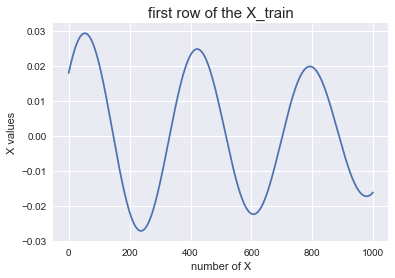

In [41]:
# your code here
plt.plot(X_train[0]) #first row
plt.title("first row of the X_train", fontsize=15)
plt.xlabel("number of X")
plt.ylabel("X values");

**7.2** The first row of the `y_train` data is $[0.024, 0.533, 0.018, 0.558]$. Visually or numerically verify that the first row of X_train is 1000 equally-spaced samples in $[0,10\pi]$ from the function $f(x) = 0.024\sin(0.533\,x) + 0.018\cos(0.558\,x)$. This pattern (y_train is the true parameters of the curve in X_train) will always hold.

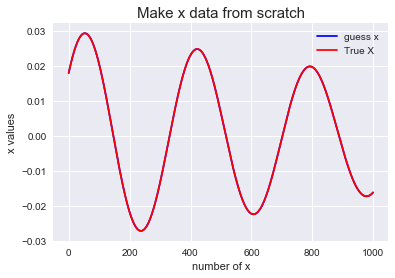

In [58]:
# your code here
#Visually verify

#make 1000 equally spaced samples.
data =np.linspace(0,10*np.pi,1000)

def curve(x): #define function f(x)
    return 0.024*np.sin(0.533*x)+0.018*np.cos(0.558*x)

x = curve(data) #change data to x

plt.plot(x, color='b',label="guess x")
plt.plot(X_train[0], color='r', label="True X") #first row

plt.title("Make x data from scratch", fontsize=15)
plt.xlabel("number of x")
plt.ylabel("x values"); # Look quiet similar to X_train
plt.legend();

In [43]:
np.sum(X_train[0]!=x) #Verify it numerically,
#every value is same

0

**7.3** Use `Sequential` and `Dense` from Keras to build a fully-connected neural network. You can choose any number of layers and any number of nodes in each layer. 

In [44]:
X_train.shape

(10000, 1000)

In [45]:
# your code here

NNmodel = Sequential([
    Dense(750, input_shape=(1000,), activation='relu'),
    Dense(350, activation='relu'),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(10, activation='relu'),
    Dense(4, activation='softmax')
])

**7.4** Compile your model via the line `model.compile(loss='mean_absolute_error', optimizer='adam')` and display the `.summary()`. Explain why the first layer in your network has the indicated number of parameters.

In [46]:
# your code here
NNmodel.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])
#use accuracy for evaluating Qw7.6
NNmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 750)               750750    
_________________________________________________________________
dense_2 (Dense)              (None, 350)               262850    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               35100     
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 44        
Total params: 1,054,304
Trainable params: 1,054,304
Non-trainable params: 0
_________________________________________________________________


----
Your answer here

----
Number of parameter in the first layer is 750750.

This is obtained as 1000 (input values) * 750 (neurons in the first layer) + 750 (bias values).

The bias value allows to shift the activation function to the left or right, which may be critical for successful learning.


**7.5** Fit your model to the data for 50 epochs using a batch size of 32 and a validation split of .2. You can train for longer if you wish- the fit tends to improve over time.

In [47]:
# your code here
NNmodel.fit(X_train, y_train, epochs=50, batch_size=32, validation_split = .2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 9s 1ms/step - loss: 0.2759 - acc: 0.4845 - val_loss: 0.2653 - val_acc: 0.5695
Epoch 2/50
8000/8000 [==============================] - 8s 953us/step - loss: 0.2642 - acc: 0.5842 - val_loss: 0.2610 - val_acc: 0.5815
Epoch 3/50
8000/8000 [==============================] - 7s 936us/step - loss: 0.2606 - acc: 0.6181 - val_loss: 0.2598 - val_acc: 0.6225
Epoch 4/50
8000/8000 [==============================] - 8s 959us/step - loss: 0.2588 - acc: 0.6450 - val_loss: 0.2576 - val_acc: 0.6205
Epoch 5/50
8000/8000 [==============================] - 8s 948us/step - loss: 0.2582 - acc: 0.6526 - val_loss: 0.2584 - val_acc: 0.6280
Epoch 6/50
8000/8000 [==============================] - 8s 1ms/step - loss: 0.2575 - acc: 0.6391 - val_loss: 0.2565 - val_acc: 0.6435
Epoch 7/50
8000/8000 [==============================] - 8s 1ms/step - loss: 0.2574 - acc: 0.6470 - val_loss: 0.2566 - val_acc: 0.6600
Epoch 

**7.6** Use the `plot_predictions` function to plot the model's predictions on `X-test` to the true values in `y_test` (by default, it will only plot the first few rows). Report the model's overall loss on the test set. Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefecients that generated the data?




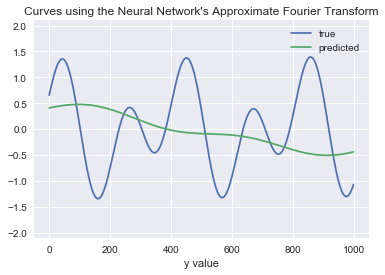

true: [0.86199664 0.98175913 0.65523998 0.4870337 ]
predicted: [0.09860321 0.38285792 0.40883714 0.10970179]


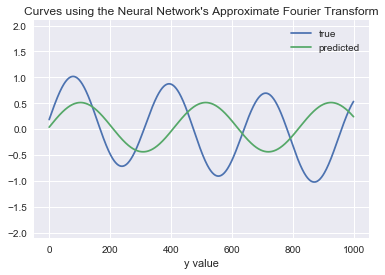

true: [0.8406355  0.63159555 0.18328701 0.11174618]
predicted: [0.47576433 0.48599017 0.03668717 0.00155834]


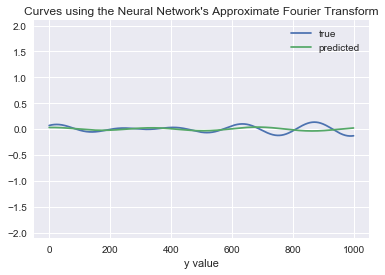

true: [0.06591224 0.75183886 0.06986143 0.91352303]
predicted: [0.00819191 0.37840042 0.03056686 0.58284086]


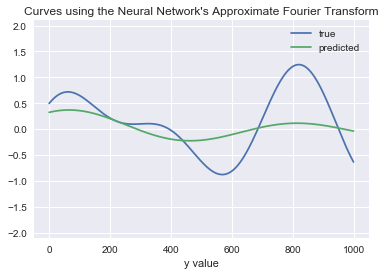

true: [0.75610725 0.30861152 0.49522059 0.48394499]
predicted: [0.22136766 0.20078494 0.3235096  0.2543378 ]


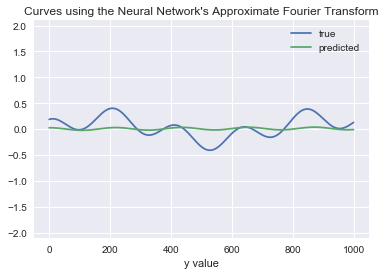

true: [0.2229353  0.27885697 0.18696198 0.94846283]
predicted: [0.01283995 0.04285949 0.02610584 0.9181948 ]


In [59]:
# your code here
plot_predictions(NNmodel,X_test,y_test)









In [49]:
NNmodel.evaluate(X_test, y_test)

2000/2000 [==============================] - 0s 148us/step


[0.25728775668144227, 0.6315]

----
Your answer here

----
model's overall loss is about 0.25

I do not think that this model learned perfectly how to map it in 50 epoch.

Evaluate accuracy score is about 0.66. 

**7.7** Examine the model's performance on the 9 train/test pairs in the `extended_test` variables. Which examples does the model do well on, and which examples does it struggle with?

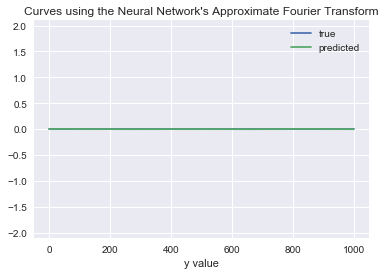

true: [0. 0. 0. 0.]
predicted: [0.0007563  0.5145967  0.00199162 0.48265535]


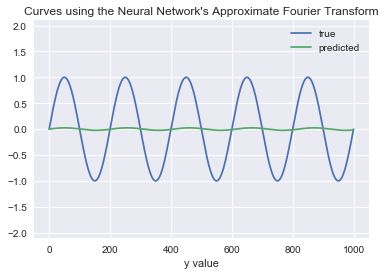

true: [1. 1. 0. 0.]
predicted: [2.3838075e-02 9.7615981e-01 1.3697397e-06 7.4018374e-07]


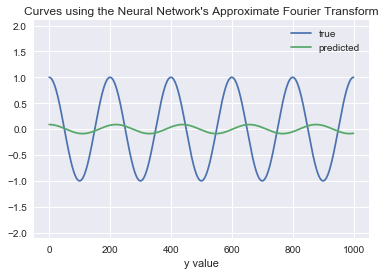

true: [0. 0. 1. 1.]
predicted: [2.2411835e-17 1.8564437e-10 8.7742455e-02 9.1225755e-01]


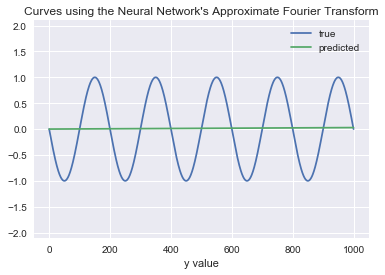

true: [-1.  1.  0.  0.]
predicted: [9.8964089e-01 9.2745124e-04 1.8322483e-12 9.4317524e-03]


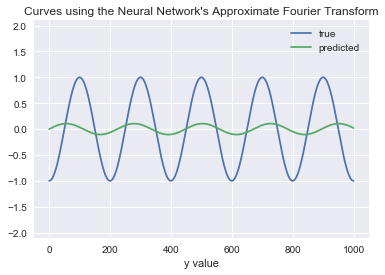

true: [ 0.  0. -1.  1.]
predicted: [1.0585213e-01 8.9370042e-01 1.3065288e-12 4.4743181e-04]


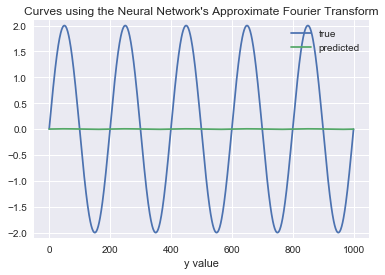

true: [2. 1. 0. 0.]
predicted: [4.7843908e-03 9.9521565e-01 6.4447468e-11 1.7099458e-12]


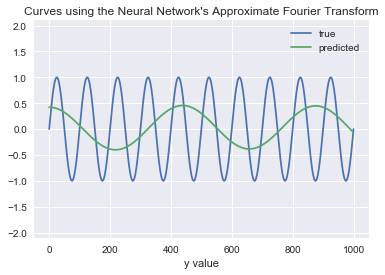

true: [1. 2. 0. 0.]
predicted: [0.03800057 0.08446609 0.4210533  0.45648006]


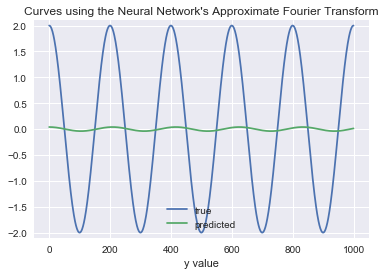

true: [0. 0. 2. 1.]
predicted: [4.7709819e-32 1.3198283e-19 3.9607484e-02 9.6039253e-01]


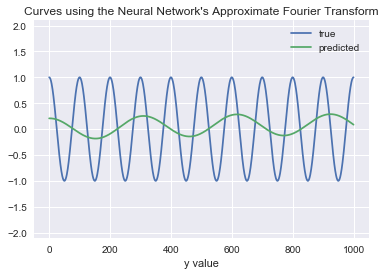

true: [0. 0. 1. 2.]
predicted: [0.08285409 0.06105725 0.20724894 0.6488397 ]


In [50]:
# your code here
plot_predictions(NNmodel,X_extended_test, y_extended_test)

In [51]:
NNmodel.evaluate(X_extended_test, y_extended_test)

9/9 [==============================] - 0s 814us/step


[0.5288928747177124, 0.1111111119389534]

----
Your answer here

----

model's overall loss is about 0.53

It is pretty a lot, this model is apparently struggling to perform on almost of the extended_test set.

Except first, zero line.

Evaluate accuracy score is about 0.2. Also very low score.

**7.8** Is there something that stands out about the difficult observations, especially with respect to the data the model was trained on? Did the model learn the mapping we had in mind? Would you say the model is overfit, underfit, or neither?

----
Your answer here

----
It is not overfitted despite the fact that it has a plenty of predictors.

And it could learn something on the data to find 4 result without many conditions (in this case).

At least it predicts the results have some similarity on test set

The model did learn how to map it, but not like having in mind. Not well. 

Just shape is similar to True values, but accuracy is pretty bad.

I would say it is underfit due to performance on extended data.

It's epoch was 50, which takes a lot of times.

But result is not that enough..